In [1]:
import numpy as np

class PrimalDualSolver_logistic:
    def __init__(self, theta, b, x_i, y_i, D, lambda_0, lambda_1, lambd, mu, tol=1e-6, max_iter=1000):
        """
        This Primal-Dual Solver aim to solve the following optimization problem:
        \min_{alpha} {f1(alpha) + f2(alpha) + \lambda_1 ||alpha||_1}
        where f1(alpha) = C(y_i (theta^T alpha - b)) with C(x) = log(1 + exp(-x))
        and f2(alpha) = lambda_0 ||x_i - D alpha||^2 + lambda_1 ||alpha||_1

        Initialize the solver with problem parameters.

        Parameters:
            theta: Parameter vector for f1 (np.ndarray).
            b: Scalar bias term for f1 (float).
            x_i: Input vector for f2 (np.ndarray).
            y_i: Target value for f1 (float).
            D: Dictionary matrix for f2 (np.ndarray).
            lambda_0: Regularization parameter for f2 (float).
            lambda_1: Regularization parameter for f3 (float).
            lambd: Step size (float).
            mu: Scaling factor (float).
            tol: Convergence tolerance (float).
            max_iter: Maximum number of iterations (int).
        """
        self.theta = theta
        self.b = b
        self.x_i = x_i
        self.y_i = y_i
        self.D = D
        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambd = lambd
        self.mu = mu
        self.tol = tol
        self.max_iter = max_iter

    def gradient_f1(self, alpha):
        """Gradient of f1 with respect to alpha."""
        inner_product = np.dot(self.theta.T, alpha) + self.b

        # Compute the exponential term
        exp_term = np.exp(-self.y_i * inner_product)

        # Compute the gradient
        gradient = -exp_term / (1 + exp_term) * self.y_i * self.theta.T

        return gradient

    def gradient_f2(self, alpha):
        """Gradient of f2 with respect to alpha."""
        return 2 * self.lambda_0 * (self.D.T @ (self.D @ alpha - self.x_i))

    @staticmethod
    def prox_l1(v, lambd):
        """Proximal operator for the L1 norm with lambda."""
        return np.sign(v) * np.maximum(np.abs(v) - lambd, 0)

    def objective(self, alpha):
        """Compute the objective function value."""
        x = self.y_i * self.theta.T @ alpha + self.b
        f1 = np.log(1 + np.exp(-x))
        f2 = self.lambda_0 * np.linalg.norm(self.x_i - self.D @ alpha) ** 2
        f3 = self.lambda_1 * np.linalg.norm(alpha, 1)
        return f1 + f2 + f3

    def solve(self, x0):
        """
        Solve the optimization problem using the primal-dual splitting algorithm.

        Parameters:
            x0: Initial value of alpha (np.ndarray).

        Returns:
            alpha: Optimized alpha (np.ndarray).
            history: List of objective function values at each iteration (list).
        """
        alpha = x0
        history = []

        for k in range(self.max_iter):
            # Compute gradients
            grad_f1 = self.gradient_f1(alpha)
            grad_f2 = self.gradient_f2(alpha)
            grad_f = grad_f1 + grad_f2

            # Update rule
            alpha_new = self.mu * self.prox_l1(alpha - self.lambd * grad_f, self.lambd * self.lambda_1)

            # Convergence check
            if np.linalg.norm(alpha_new - alpha) < self.tol:
                break

            # Update alpha and track function value
            alpha = alpha_new
            history.append(self.objective(alpha))

        return alpha, history

True alpha: [ 0.          1.01051528  0.          0.          0.         -0.58087813
  0.          0.          0.27904129  0.        ]
Estimated alpha: [ 0.          0.93913594 -0.25137255  0.         -0.13564585 -0.40857669
  0.06370458  0.03770769  0.57633253 -0.13957292]
Difference (norm): 0.47928444560555955


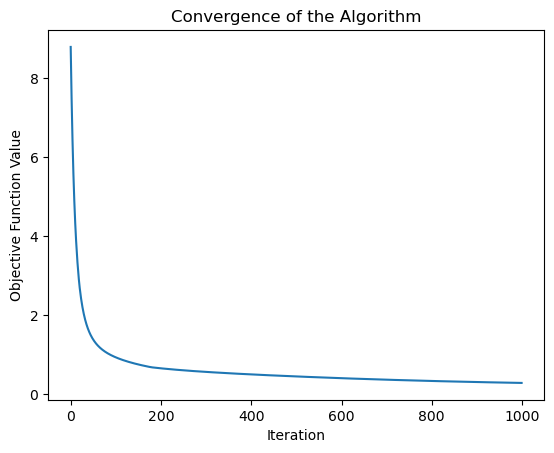

In [2]:
import numpy as np

def generate_data(n_features, n_samples, sparsity, noise_level=0.01):
    """
    Generate synthetic data for the optimization problem.

    Parameters:
        n_features: Number of features (dimension of alpha).
        n_samples: Number of data samples.
        sparsity: Number of nonzero elements in alpha_true.
        noise_level: Standard deviation of added noise.

    Returns:
        alpha_true: True alpha vector (np.ndarray).
        x_i: Input vector for f2 (np.ndarray).
        y_i: Target value for f1 (float).
        theta: Parameter vector for f1 (np.ndarray).
        b: Scalar bias term for f1 (float).
        D: Dictionary matrix for f2 (np.ndarray).
    """
    # True alpha (sparse vector)
    alpha_true = np.zeros(n_features)
    nonzero_indices = np.random.choice(n_features, sparsity, replace=False)
    alpha_true[nonzero_indices] = np.random.randn(sparsity)

    # Generate D (random matrix)
    D = np.random.randn(n_features, n_features)

    # Generate x_i consistent with alpha_true
    x_i = D @ alpha_true + noise_level * np.random.randn(n_features)

    # Generate theta (random vector) and bias term
    theta = np.random.randn(n_features)
    b = np.random.randn()

    # Generate y_i consistent with alpha_true
    y_i = theta.T @ alpha_true + b + noise_level * np.random.randn()

    return alpha_true, x_i, y_i, theta, b, D

# Generate synthetic data
np.random.seed(42)
n_features = 10
n_samples = 1
sparsity = 3
alpha_true, x_i, y_i, theta, b, D = generate_data(n_features, n_samples, sparsity)

# Initialize parameters
x0 = np.random.randn(n_features)  # Random initialization
lambda_0 = 0.1
lambda_1 = 0.1
lambd = 0.01
mu = 1.0

solver = PrimalDualSolver_logistic(
    theta=theta, b=b, x_i=x_i, y_i=y_i, D=D,
    lambda_0=0.1, lambda_1=0.1, lambd=0.01, mu=1.0
)

# Solve the problem
x0 = np.random.randn(n_features)  # Random initialization
alpha_opt, history = solver.solve(x0)


# Compare the result with the true alpha
print("True alpha:", alpha_true)
print("Estimated alpha:", alpha_opt)
print("Difference (norm):", np.linalg.norm(alpha_opt - alpha_true))

# Plot the convergence history
import matplotlib.pyplot as plt

plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence of the Algorithm")
plt.show()
